# **사이킷런으로 수행하는 타이타닉 생존자 예측**

**변수 별 정보**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- Passengerid : 탑승자 데이터 일련번호
- Survived : 생존 여부
  - 0 = 사망, 1 = 생존
- Pclass : 티켓의 선실 등급
  - 1 = 일등석, 2 = 이등석, 3 = 삼등석
- Name : 탑승자 이름
- Sex : 탑승자 성별
- Age : 탑승자 나이
- SibSp : 같이 탑승한 형제자매 또는 배우자 인원수
- Parch : 같이 탑승한 부모님 또는 어린이 인원수
- Ticket : 티켓 번호
- Fare : 요금
- Cabin : 선실 번호
- Embarked : 중간 정착 항구
    - C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
titanic_df.shape

(891, 12)

In [4]:
# 타이타닉 칼럼 타입 확인
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**데이터 정보 확인**
- RangeIndex : 891 entries, 0 to 890 : 전체 행 (891개 행)
    - 데이터 개수 : 891개
- Data columns (total 12 columns) : 칼럼 수(12개)
    - 속성(columns) 개수 : 12개
- 수치형 데이터 : float (2개)
- 정수형 데이터 : int (5개)
- 범주형 데이터 : object (5개)
    - 판다스는 넘파이 기반으로 만들어졌는데, 넘파이의 String타입의 길이 제한이 있기 때문에, 이에 대한 구분을 위해 object타입으로 명기
- Non-Null : 결측치가 아닌 개수 = 실제 가지고 있는 데이터 개수
- Age : 714개 
    - Null값 (NaN) : 177개
- Cabin : 204개 
    - Null값 (NaN) : 687개
- Embarked : 889개 
    - Null값 (NaN) : 2개

## 결측치 파악

In [5]:
# Null 값 개수 확인
titanic_df['Age'].isnull().sum()

177

In [6]:
titanic_df['Cabin'].isnull().sum()

687

In [7]:
titanic_df['Embarked'].isnull().sum()

2

## 데이터 전처리 : 결측치 처리

### **Null 컬럼들에 대한 처리**
- 사이킷 머신러닝 알고리즘은 Null값을 허용하지 않으므로
- Null값을 어떻게 처리할지 결정
- DataFrame()의 fillna()메서드를 사용해서 Null값을 평균 또는 고정 값으로 변경
- Age : 평균 나이로 변경
- 나머지 컬럼 : 'N'으로 변경

In [8]:
titanic_df['Age'].mean()

29.69911764705882

In [9]:
# Null 처리
titanic_df['Age'].fillna(titanic_df['Age'].mean, inplace = True)
titanic_df['Cabin'].fillna("N", inplace = True)
titanic_df['Embarked'].fillna("N", inplace = True)

# 모든 컬럼의 Null값을 합산해서 Null 값이 없는지 확인
titanic_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### **문자열 변수(피처) 빈도 분포 확인 : value_counts()**

In [10]:
# 문자열 피처 (Sex, Cabin, Embarked) 값 분류 확인
print('Sex 분포 : \n', titanic_df['Sex'].value_counts())
print('\nCabin 분포 : \n', titanic_df['Cabin'].value_counts())
print('\nEmbarked 분포 : \n', titanic_df['Embarked'].value_counts())

Sex 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

Cabin 분포 : 
 N              687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
              ... 
E63              1
E77              1
B80              1
C45              1
D11              1
Name: Cabin, Length: 148, dtype: int64

Embarked 분포 : 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


Cabin, Embarked에서 "N"은 결측치 처리 된 것

### **문자열 변수 Cabin값 변경**

In [11]:
# Cabin 칼럼 값 중에서 첫 번째 문자만 추출
titanic_df['Cabin'].str[:1]

0      N
1      C
2      N
3      C
4      N
      ..
886    N
887    B
888    N
889    C
890    N
Name: Cabin, Length: 891, dtype: object

In [12]:
# Cabin값을 선실등급만으로 표기 (선실 번호 제외)
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]

# 선실등급 별 개수 확인
titanic_df['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

### **성별에 따른 생존자수 분포 (EDA)**
머신러닝 알고리즘 적용해서 예측 수행 전에 데이터 탐색
- 어떤 유형의 승객이 생존 확률이 높았는지 확인
- 성별이 생존 확률에 어떤 영향을 미쳤는지 확인
- 성별에 따른 생존자 수 비교

In [12]:
# 성별(Sex) 분포 확인
titanic_df.groupby('Sex')['Sex'].count()

Sex
female    314
male      577
Name: Sex, dtype: int64

In [13]:
# 생존(Survived) 분포 확인
# 0 : 사망 / 1 : 생존
titanic_df.groupby('Survived')['Survived'].count()

Survived
0    549
1    342
Name: Survived, dtype: int64

In [14]:
# 성별-생존 확인
# 0 : 사망 / 1 : 생존
# 생존(Survived)칼럼 : 레이블로 결정 클래스 값
# 교차표 확인

titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

여자 : 314명 중 233명 생존 (약 74.2% 생존)

남자 : 577명 중 109명 생존 (약 18.8% 생존)

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

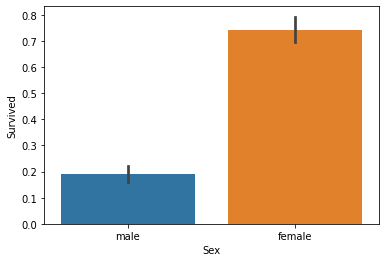

In [15]:
# 성별 생존자 : 막대 그래프 (barplot)
sns.barplot(x = 'Sex', y = 'Survived', data = titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

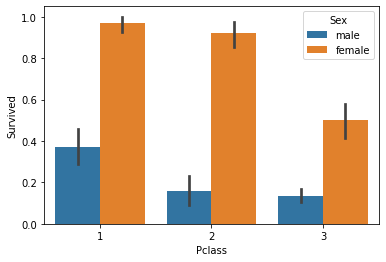

In [16]:
# 객실 등급별 / 성별 생존 확률
sns.barplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = titanic_df)

**등급별 생존**

여성 : 1, 2등실에 따른 생존 확률의 차이는 크지 않으나 3등실의 경우 생존 확률이 상대적으로 떨어짐

남자 : 2, 3등실 보다 1등실 생존 확률이 월등히 높음

## 데이터 전처리 : 구간화 (binning)

### **연령대에 따른 생존자수 분포**
- 연령은 수치형 변수이므로 범주형으로 구간화 (**binning**)

범주형, 수치형 데이터: 명목 순서 비율 구간

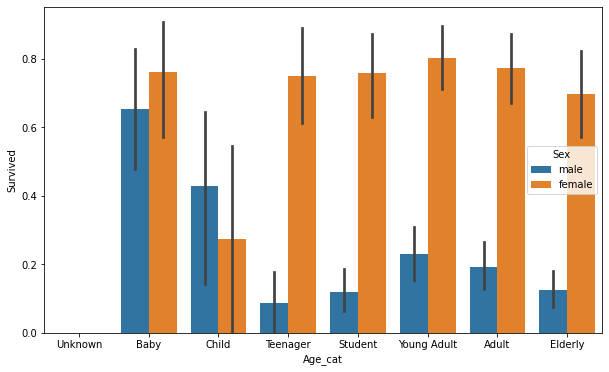

In [24]:
# 연령별(Age) 생존 확률 확인
# Age의 값 종류가 많기 때문에 범위별로 분류해 카테고리 값 할당

# 입력 age에 따라 구분값을 반환하는 함수 설정
# DataFrame의 apply lambda식에 사용
def get_category(age):
    cat = ''
    if age <= -1 : cat = 'Unknown'        # -1 이하 오류 값
    elif age <= 5 : cat = 'Baby'          # 0 ~ 5세 
    elif age <= 12 : cat = 'Child'        # 6 ~ 12세
    elif age <= 18 : cat = 'Teenager'     # 13 ~ 18세 
    elif age <= 25 : cat = 'Student'      # 19 ~ 25세
    elif age <= 35 : cat = 'Young Adult'  # 26 ~ 35세
    elif age <= 60 : cat = 'Adult'        # 36 ~ 60세
    else : cat = 'Elderly'                # 61세 이상
    
    return cat

# 막대 그래프의 크기 figure를 더 크게 설정
plt.figure(figsize = (10, 6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category()함수를 반환값으로 지정
# get_category(X)는 입력값으로 'Age'컬럼값을 받아서 해당하는 cat반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x = 'Age_cat', y = 'Survived', hue ='Sex', data = titanic_df, order = group_names)
titanic_df.drop('Age_cat', axis = 1, inplace = True)

## 데이터 전처리 : 인코딩

### **문자열 카테고리 피처를 숫자형 카테고리 피처로 변환**
- 인코딩 : 사이킷런의 LabelEncoder 클래스 이용해서 레이블 인코딩 적용
- 0 ~ (카테고리 유형 수 - 1) 숫자 값으로 변환
- fit() / transform() 메서드 사용

In [14]:
from sklearn import preprocessing

# 레이블 인코딩 함수
# 개선 : def encode_feature(dataDF, feature):
def encode_features(dataDF):
    # 문자열 카테고리 피러
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


## 데이터 전처리 : 삭제
- PassengerID, Name, Ticket 변수 삭제
- drop(labels = None, axis = 0, inplace = False) 함수 사용

In [15]:
# 불필요한 변수 제거 drop()함수 : PassengerId, Name, Ticket 변수
titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,3
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,7,3


In [16]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna("N", inplace = True)
    df['Embarked'].fillna("N", inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df


# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]  # 첫 문자만 추출
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

## 생존자 예측 프로세스

### **1단계. 데이터 로딩**
- 피처 데이터셋, 레이블 데이터 셋 추출

In [17]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv('titanic_train.csv')
# 결정값
y_titanic_df = titanic_df['Survived']
# 학습 데이터 세트
# 결정 값으로 사용할 'Survived' 칼럼 제외
X_titanic_df = titanic_df.drop('Survived', axis = 1)

### **2단계. 데이터 전처리**
- 피처 데이터 세트에 transform_features()를 적용해 데이터 가공

In [18]:
# 데이터 전처리 함수 호출
X_titanic_df = transform_features(X_titanic_df)
X_titanic_df.head(5)
# 생존자 예측을 수행할 피처 데이터 세트 완성

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,7,3
1,1,0,38.0,1,0,71.2833,2,0
2,3,0,26.0,0,0,7.9250,7,3
3,1,0,35.0,1,0,53.1000,2,3
4,3,1,35.0,0,0,8.0500,7,3


### **3단계. Data Split : 학습 데이터/테스트 데이터**

In [19]:
# 학습 / 테스트 데이터 세트 분리
# 테스트 데이터 세트 : 20%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

### **4단계. 분류 알고리즘을 적용한 학습 / 예측 / 평가**
- 3개의 ML 알고리즘 수행
    - 결정 트리, 랜덤 포레스트, 로지스틱 회귀(분류)
- 이 3개의 알고리즘으로 예측 수행하고
- 교차 검증으로 평가

**사이킷런 클래스**
- 결정 트리 : DecisionTreeClassifier
- 랜덤 포레스트 : RandomForestClassifer
- 로지스틱 회귀 : LogisticRegression

**train_test_split()으로 분리한 학습 데이터와 테스트 데이터를 기반으로**
- 머신러닝 모델을 학습하고(fit), 예측 수행(predict)
- 예측 성능 평가 : 정확도 (accuracy_score() 사용)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 위한 estimator 객체 생성
dt_clf = DecisionTreeClassifier(random_state = 12)
rf_clf = RandomForestClassifier(random_state = 12)
lr_clf = LogisticRegression()

# 결정 트리 학습 / 예측 / 평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('결정 트리의 정확도 : {0:.4f}' .format(accuracy_score(y_test, dt_pred)))

# 랜덤 포레스트 학습 / 예측 / 평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('랜덤 포레스트의 정확도 : {0:.4f}' .format(accuracy_score(y_test, rf_pred)))

# 로지스틱 회귀 학습 / 예측 / 평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('로지스틱 회귀의 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

결정 트리의 정확도 : 0.8101
랜덤 포레스트의 정확도 : 0.8659
로지스틱 회귀의 정확도: 0.8492


C:\Users\ftsv2\Anaconda3\envs\multi\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### **5단계. 교차 검증을 통한 모델 성능 향상**
: 결정 트리 모델 좀 더 평가
- 사이킷런 model_selection 패키지의
    - KFold클래스, cross_val_score(), GridSearchCV클래스 사용

In [27]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# 결정 트리 모델에 대해 KFold클래스를 이용해 교차 검증 수행
def exec_kfold(clf, folds = 5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits = folds)
    scores = []
    
    # KFold 교차 검증 수행
    # enumerate : 인덱스를 붙여주는 것 (인덱스 열거)
    for iter_n, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        scores.append(accuracy)
        print('교차검증 %d : %f' %(iter_n, accuracy))
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_accuracy = np.mean(scores)
    print('평균 정확도 : %f' %mean_accuracy)

# exec_kfold 호출
exec_kfold(dt_clf, folds = 5)

교차검증 0 : 0.748603
교차검증 1 : 0.769663
교차검증 2 : 0.792135
교차검증 3 : 0.764045
교차검증 4 : 0.808989
평균 정확도 : 0.776687


In [46]:
# cross_val_score()를 이용해 교차 검증 수행
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv = 5)
for iter_n, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도 : {1:.4f}' .format(iter_n, accuracy))

print('평균 정확도 : {0:.4f}' .format(np.mean(scores)))

교차 검증 0 정확도 : 0.7430
교차 검증 1 정확도 : 0.7753
교차 검증 2 정확도 : 0.7921
교차 검증 3 정확도 : 0.7865
교차 검증 4 정확도 : 0.8427
평균 정확도 : 0.7879


### **6단계. 하이퍼 파라미터 튜닝**

In [21]:
# GridSearchCV클래스를 이용해 하이퍼 파라미터를 튜닝
# DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능 측정
# CV : 5개의 폴드 세트 지정
# 하이퍼 파라미터 : max_depth, min_samples_split, min_samples_leaf

from sklearn.model_selection import GridSearchCV

In [59]:
# 하이퍼 파라미터 설정
parameters = {'max_depth':[2, 3, 5, 10], 'min_samples_split':[2, 3, 5], 'min_sampes_leaf':[1, 5, 8]}

In [62]:
grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring = 'accuracy', cv = 5)
grid_dclf.fit(X_train, y_train)

ValueError: Invalid parameter min_sampes_leaf for estimator DecisionTreeClassifier(max_depth=2, random_state=12). Check the list of available parameters with `estimator.get_params().keys()`.

In [63]:
grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

ValueError: Invalid parameter min_sampes_leaf for estimator DecisionTreeClassifier(max_depth=2, random_state=12). Check the list of available parameters with `estimator.get_params().keys()`.

In [56]:
print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_
      

In [56]:
# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

ValueError: Invalid parameter min_sampes_leaf for estimator DecisionTreeClassifier(max_depth=2, random_state=12). Check the list of available parameters with `estimator.get_params().keys()`.

In [22]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715
